# 1. Predicting MBTI Types for Twitter User Comments Dataset

I predict the MBTI types for each user based on their comments. The process involves several key steps: 

1. the user comments undergo a thorough text cleaning process. This includes converting the text to lowercase, removing unnecessary punctuation, symbols, URLs, HTML tags, and stripping any leading or trailing spaces. The cleaning is performed using the `TextCleaner` class, which systematically applies these transformations to ensure the text data is in a consistent format suitable for analysis.

2. Leverage a pre-trained Linear Support Vector Classifier (SVC) model, identified earlier as the most effective model through rigorous comparison with other classifiers. The cleaned text is vectorized using a TF-IDF vectorizer to convert it into a format that the model can process. The model then predicts the MBTI type for each comment. 

3.  the predicted MBTI types are appended to the dataset as a new column. The updated dataset is saved to a CSV file for further analysis. 

In [2]:
import pandas as pd
import joblib
import re

#define a text cleaner class
class TextCleaner:
    def clean_text(text):
        #convert text to lowercase and remove specific punctuation and symbols
        text = re.sub(r"[-()\"#/@;:<>{}+=~|.,?]", "", text.lower())
        #replace '|||' with a space
        text = re.sub(r'\|\|\|', ' ', text)
        #remove URLs and HTML tags
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        #strip leading and trailing spaces，ref:https://www.w3schools.com/python/ref_string_strip.asp
        return text.strip()

#load the saved model, vectorizer, and label encoder
model_linear_SVC = joblib.load('mbti_linear_svc_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
target_encoder = joblib.load('label_encoder.pkl')
#load dataset
data = pd.read_csv('data/combined_comment.csv')

#define a function to clean the text and predict the MBTI type
def predict_mbti(text, vectorizer, model, target_encoder):
    #clean the text
    text_clean = TextCleaner.clean_text(text)
    #vectorize the cleaned text
    text_vectorized = vectorizer.transform([text_clean]).toarray()
    #predict the MBTI type
    prediction = model.predict(text_vectorized)
    #convert the prediction to the original MBTI type
    mbti_type = target_encoder.inverse_transform(prediction)
    #return the predicted MBTI type
    return mbti_type[0]

#apply the MBTI prediction function to each row in the dataset
data['MBTI'] = data['text'].apply(lambda x: predict_mbti(x, vectorizer, model_linear_SVC, target_encoder))
#save the results to a new CSV file
data.to_csv('data/dataset_with_mbti.csv', index=False)  
#print the first few rows of the updated dataset
print(data.head())

    brand         username                 created_at  \
0  Chanel  honeypeach13964  2024-08-31 04:16:25+00:00   
1  Chanel    stan_nofandom  2024-08-31 03:49:56+00:00   
2  Chanel     AntonioDieho  2024-08-31 02:25:10+00:00   
3  Chanel          TSYNWJ3  2024-08-30 17:57:51+00:00   
4  Chanel     saltestocean  2024-08-30 13:12:47+00:00   

                                                text  MBTI  
0                          @NewJeans_ADOR @CHANEL 好看  INTP  
1               @NewJeans_ADOR @CHANEL Perfect face😍  INFJ  
2            @NewJeans_ADOR @CHANEL Minji te amooooo  INTJ  
3  @NewJeans_ADOR @CHANEL the denim short is so c...  INTP  
4       @gelatlo @NewJeans_ADOR @CHANEL ☹️☹️☹️☹️☹️☹️  INTP  


### Initial review of MBTI distribution

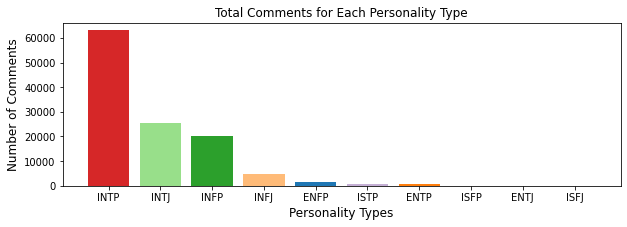

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import matplotlib.colors as mcolors
import plotly.express as px  

data = pd.read_csv('data/dataset_with_mbti.csv')

#use the tab20 colormap,ref:https://matplotlib.org/stable/users/explain/colors/colormaps.html
tab20 = plt.get_cmap('tab20').colors
#sort the unique MBTI types from the dataset 
mbti_types = sorted(data['MBTI'].unique())  
#create a dictionary mapping each MBTI type to a color from the 'tab20' palette
color_map = {mbti: tab20[i % len(tab20)] for i, mbti in enumerate(mbti_types)}

#calculate the distribution of MBTI types using value_counts,ref:https://www.kaggle.com/code/anandu08/psycho-analysis-nlp-fr-enhanced-social-media-con/notebook#Performance-Visualisation
mbti_distribution = data['MBTI'].value_counts(normalize=False) * 50
#reset the index and rename the columns,ref:https://www.w3schools.com/python/pandas/ref_df_reset_index.asp
mbti_distribution_df = mbti_distribution.reset_index()
mbti_distribution_df.columns = ['MBTI', 'count']

#plot the distribution of MBTI types
plt.figure(figsize=(10, 3))
plt.bar(mbti_distribution.index, height=mbti_distribution.values, color=[color_map[mbti] for mbti in mbti_distribution.index])
plt.xlabel('Personality Types', size=12)
plt.ylabel('Number of Comments', size=12)
plt.title('Total Comments for Each Personality Type')
plt.show()

#create a pie chart,ref:https://plotly.com/python/pie-charts/
#iterate over each MBTI type in the column and map it to its corresponding hexadecimal color code,ref:https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.to_hex.html
fig = px.pie(data_frame=mbti_distribution_df, names='MBTI', values='count', title='Distribution of Personality Types',hole=0.2,color='MBTI',color_discrete_map={mbti: mcolors.to_hex(color_map[mbti]) for mbti in mbti_distribution_df['MBTI']})
fig.show()

### Wordcloud For Each Independent Class

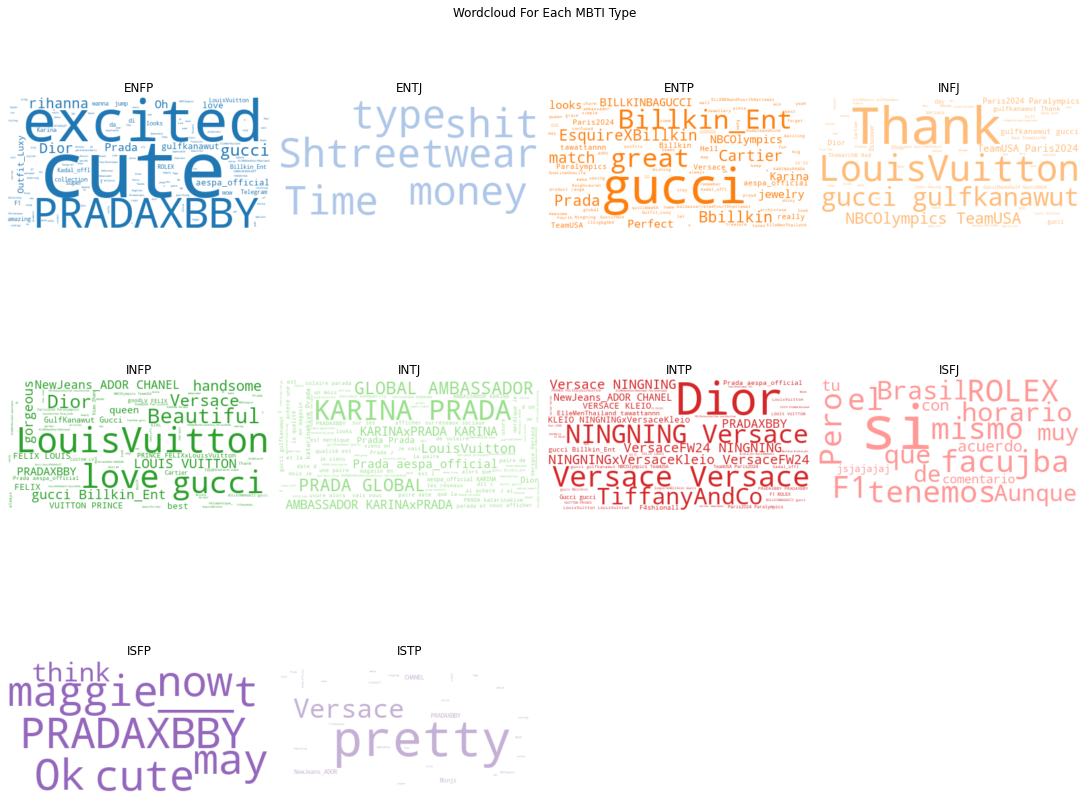

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import numpy as np

#define a broader list of stopwords,ref:https://www.kaggle.com/code/anandu08/psycho-analysis-nlp-fr-enhanced-social-media-con/notebook#Performance-Visualisation
stopwords = set(WordCloud().stopwords)
stopwords.update(["http", "https", "co", "t", "rt", "amp", "nbsp", "u", "f", "k", "like", "im", "get", "one", "would", "also", "even"])

#calculate the number of rows and columns for the grid layout
num_classes = len(mbti_types)
num_rows = num_classes // 4 + (1 if num_classes % 4 != 0 else 0)
num_cols = min(4, num_classes)

#create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows), constrained_layout=True)
plt.suptitle("Wordcloud For Each MBTI Type")

#flatten the array of axes if it is not already flat
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

#generate a word cloud for each MBTI type
for mbti_type, ax in zip(mbti_types, axs.flat):
    df_type = data[data['MBTI'] == mbti_type]
    wordcloud = WordCloud(max_words=1628, relative_scaling=1, normalize_plurals=False, background_color='white', stopwords=stopwords,color_func=lambda *args, **kwargs: mcolors.to_hex(color_map[mbti_type])).generate(' '.join(df_type['text'].tolist()))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(mbti_type)
    ax.axis("off")

#hide any remaining subplots that are not used
for ax in axs.flat[num_classes:]:
    ax.set_visible(False)
plt.show()

# 2. Further text cleaning and language translation
The translation step using Google Translator was introduced to ensure consistency across multilingual text, and preprocessing was enhanced with lemmatization, stopword removal, and stricter cleaning, improving feature extraction and model prediction accuracy.

In [5]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from deep_translator import GoogleTranslator

#download the stopwords and WordNet corpora from NLTK,ref:https://www.kaggle.com/code/anandu08/psycho-analysis-nlp-fr-enhanced-social-media-con/notebook#Performance-Visualisation
nltk.download('stopwords')
nltk.download('wordnet')
#initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_and_translate_text(text):
    #remove URLs and convert text to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text.lower())  
    #remove HTML tags from the text
    text = re.sub(r'<.*?>', '', text) 
    #remove punctuation and numbers, keeping only words and spaces 
    text = re.sub(r'[^\w\s]', '', text) 
    #remove leading and trailing whitespace,ref:https://www.programiz.com/python-programming/methods/string/strip
    text = text.strip()   
    #translate text,ref:https://github.com/nidhaloff/deep-translator?tab=readme-ov-file#id1
    translated_text = GoogleTranslator(source='auto', target='en').translate(text)
    #tokenize, remove stopwords, and perform lemmatization,ref:https://medium.com/@abhishekjainindore24/all-about-tokenization-stop-words-stemming-and-lemmatization-in-nlp-1620ffaf0f87
    cleaned_text = ' '.join([lemmatizer.lemmatize(word) for word in translated_text.split() if word not in stop_words])
    return cleaned_text

data = pd.read_csv('data/combined_comment.csv')
#apply the text cleaning and translation function
data['cleaned_text'] = data['text'].apply(clean_and_translate_text)
#save the cleaned and translated dataset
data.to_csv('data/cleaned_translated_dataset.csv', index=False)
print(data[['text', 'cleaned_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yinshuodi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yinshuodi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0                          @NewJeans_ADOR @CHANEL 好看   
1               @NewJeans_ADOR @CHANEL Perfect face😍   
2            @NewJeans_ADOR @CHANEL Minji te amooooo   
3  @NewJeans_ADOR @CHANEL the denim short is so c...   
4       @gelatlo @NewJeans_ADOR @CHANEL ☹️☹️☹️☹️☹️☹️   

                                 cleaned_text  
0           newjeans_ador chanel good looking  
1           newjeans_ador chanel perfect face  
2             newjeans_ador chanel minji love  
3  newjeans_ador chanel denim short chic suit  
4                gelatlo newjeans_ador chanel  


This code predicts the MBTI personality type for each cleaned text entry in a dataset using a pre-trained linear SVM model and then saves the predictions in a new CSV file.

In [23]:
#load the saved model, vectorizer, and label encoder
model_linear_SVC = joblib.load('mbti_linear_svc_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
target_encoder = joblib.load('label_encoder.pkl')

data = pd.read_csv('data/cleaned_translated_dataset_with_mbti.csv')
#handle NaN values by filling them with an empty string
data['cleaned_text'] = data['cleaned_text'].fillna('')

#define a function to vectorize the text and predict the MBTI type
def predict_mbti(text, vectorizer, model, target_encoder):
    #vectorize the cleaned text
    text_vectorized = vectorizer.transform([text]).toarray()
    #use the model to predict the MBTI type
    prediction = model.predict(text_vectorized)
    #convert the prediction to the original MBTI type label
    mbti_type = target_encoder.inverse_transform(prediction)
    return mbti_type[0]

#apply the MBTI prediction function to each row in the cleaned_text column
data['MBTI'] = data['cleaned_text'].apply(lambda x: predict_mbti(x, vectorizer, model_linear_SVC, target_encoder))
#save the dataset with the prediction results to a new CSV file
data.to_csv('data/dataset_with_mbti_2.csv', index=False)
print(data[['cleaned_text', 'MBTI']].head())

                                 cleaned_text  MBTI
0           newjeans_ador chanel good looking  INTJ
1           newjeans_ador chanel perfect face  INFJ
2             newjeans_ador chanel minji love  INFP
3  newjeans_ador chanel denim short chic suit  INTJ
4                gelatlo newjeans_ador chanel  INTP


### View Visualizations & Wordcloud Distribution

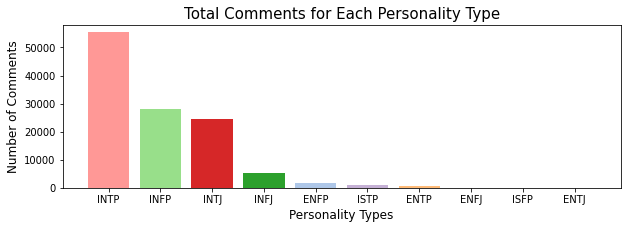

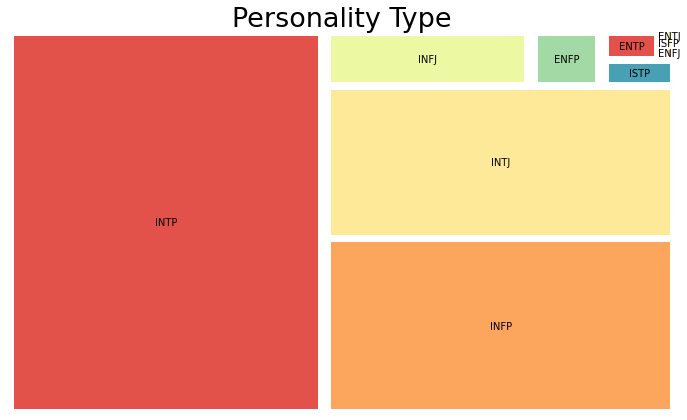

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
import matplotlib.colors as mcolors
import plotly.express as px  

#load the dataset
data = pd.read_csv('data/dataset_with_mbti_2.csv')
#use the tab20 colormap
tab20 = plt.get_cmap('tab20').colors
#sort the unique MBTI types
mbti_types = sorted(data['MBTI'].unique())  

#create a dictionary mapping each MBTI type to a color from the 'tab20' palette
color_map = {mbti: tab20[i % len(tab20)] for i, mbti in enumerate(mbti_types)}

#calculate the distribution of MBTI types
mbti_distribution = data['MBTI'].value_counts(normalize=False) * 50

#reset the index and rename the columns,ref:https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
mbti_distribution_df = mbti_distribution.reset_index()
mbti_distribution_df.columns = ['MBTI', 'count']

#plot bar chart for MBTI distribution
plt.figure(figsize=(10, 3))
plt.bar(mbti_distribution.index, height=mbti_distribution.values, color=[color_map[mbti] for mbti in mbti_distribution.index])
plt.xlabel('Personality Types', size=12)
plt.ylabel('Number of Comments', size=12)
plt.title('Total Comments for Each Personality Type', size=15)
plt.show()

#plot pie chart for MBTI distribution
fig = px.pie(data_frame=mbti_distribution_df, names='MBTI', values='count', title='Distribution of Personality Types', hole=0.2, color='MBTI', color_discrete_map={mbti: mcolors.to_hex(color_map[mbti]) for mbti in mbti_distribution_df['MBTI']})
fig.show()

#generate a treemap
count = dict(data['MBTI'].value_counts())  
plt.figure(figsize=(12, 7))
squarify.plot(sizes=count.values(), color=sns.color_palette("Spectral"), pad=2, label=count.keys())
plt.title('Personality Type', fontsize=27)
plt.axis('off')
plt.show()


# 3. Compare the quality of two datasets

<Figure size 1008x576 with 0 Axes>

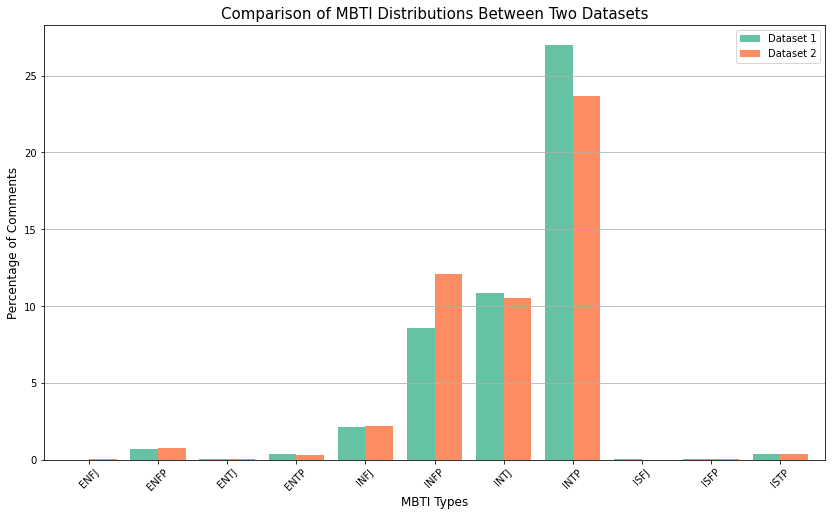

In [26]:
#load the datasets
data1 = pd.read_csv('data/dataset_with_mbti.csv')
data2 = pd.read_csv('data/dataset_with_mbti_2.csv')

#calculate the MBTI distribution for each dataset
mbti_distribution1 = data1['MBTI'].value_counts(normalize=True) * 50
mbti_distribution2 = data2['MBTI'].value_counts(normalize=True) * 50

#combine the distributions from both datasets into a single DataFrame
distribution_df = pd.DataFrame({'Dataset 1': mbti_distribution1, 'Dataset 2': mbti_distribution2}).fillna(0)

#set a seaborn color palette
colors = sns.color_palette("Set2", n_colors=2)
# visualize the comparison
plt.figure(figsize=(14, 8))
distribution_df.plot(kind='bar', figsize=(14, 8), width=0.8,color=colors)
plt.xlabel('MBTI Types', size=12)
plt.ylabel('Percentage of Comments', size=12)
plt.title('Comparison of MBTI Distributions Between Two Datasets', size=15)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()